In [1]:
import matplotlib.pylab as plt
import fitsio

Text(0.5,0,'$\\rm RA[deg.]$')

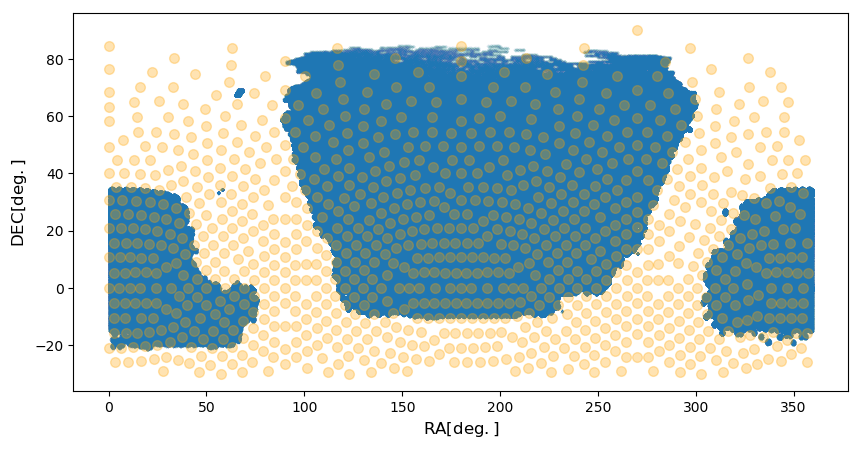

In [2]:
gfafile = '~/gfas-dr6.0-dr7.1-PR459.fits'

tilefile='~/ci-tiles-v2.fits'

citls,h=fitsio.read(tilefile,header=True)

gfa=fitsio.read(gfafile)

fig=plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(111)

plt.plot(gfa['RA'],gfa['DEC'],marker='.',linestyle='',markersize=0.1,alpha=0.1)

plt.plot(citls['RA'],citls['DEC'],marker='o',markersize=7,color='orange',alpha=0.3,linestyle='')

ax.set_ylabel(r'$\rm DEC[deg.]$', fontsize=12)
ax.set_xlabel(r'$\rm RA[deg.]$', fontsize=12)

In [3]:
import sys
import os
import os.path
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
from astropy.table import Table, Column 
import time
import datetime
from bokeh.plotting import *
from bokeh.embed import components
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, Range1d, Label, TapTool, OpenURL, CustomJS, CrosshairTool, LinearAxis
import fitsio
from bokeh.io import output_notebook
import json
from bokeh.models.widgets import RadioButtonGroup
from bokeh.layouts import column
from bokeh.models import CustomJS
from bokeh.transform import linear_cmap
from bokeh.models import CustomJS, ColumnDataSource, DateSlider, DateRangeSlider
from datetime import datetime as dt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from datetime import datetime
from astropy.time import Time, TimezoneInfo
output_notebook()

#########################################################
gfafile = '~/gfas-dr6.0-dr7.1-PR459.fits'
tilefile='~/ci-tiles-v2.fits'
citls,h=fitsio.read(tilefile,header=True)
gfa=fitsio.read(gfafile)

with open("qa.json", "r") as read_file:
    data = json.load(read_file)

#########################################################
## Coloring scheme
palette = ['green', 'red', 'orange']
dye = []
for tile in citls['TILEID']:
    rang = 0 # Default value (green)
    if str(tile) in data:
        if len(data[str(tile)]['unassigned'])>0: # not assigned (red)
            rang = 1 #'red'
    else: rang = 2  # TileID is not available in the json file (orange)
    dye.append(rang)


Loading BokehJS ...

In [4]:
def skyCircle(tt, dd):
    
    ds = str(dd[0])+'-'+str(dd[1])+'-'+str(dd[2])
    ts = str(tt[0])+':'+str(tt[1])+':'+str(tt[2])
    observatory = "kpno"
    name = "Kitt Peak National Observatory"
    Lon =  -(111 + 35/60. + 59.6/3600)
    Lat = 31.9599   
    Height = 2120.      # meter     
    
    
    obsTime = dt(dd[0],dd[1],dd[2],tt[0],tt[1],tt[2])
    reference = dt(2000,1,1,12,0,0)           # UTCref
    reference = time.mktime(reference.timetuple())
    obsTime   = time.mktime(obsTime.timetuple()) + 7*3600
    deltaT = (obsTime-reference) / (24*3600);
    
    # Convert to LST
    LST_hours = ((18.697374558 + 24.06570982441908 * deltaT) + Lon/15.) % 24;
    LST_degrees = LST_hours * 15


    obsTime = Time(ds+' '+ts)
    loc = EarthLocation(lat=Lat*u.deg, lon=Lon*u.deg, height=Height*u.m)

    zenithangle = 48.19  # deg The zenith angle at which airmass equals 1.5
    az = np.arange(0,360,3)
    alt = az*0 + (90 - zenithangle)

    newAltAzcoordiantes = SkyCoord(alt = alt, az = az, obstime = obsTime, frame = 'altaz', location = loc, unit="deg")
    ra = newAltAzcoordiantes.icrs.ra.deg
    dec = newAltAzcoordiantes.icrs.dec.deg
   
    newAltAzcoordiantes = SkyCoord(alt = [90], az = [90], obstime = obsTime, frame = 'altaz', location = loc, unit="deg")
    ra0 = newAltAzcoordiantes.icrs.ra.deg
    ra0 = ra0[0]
    ra0 = (ra-ra0)%360
    
    return ColumnDataSource({"RA0":ra0, "RA":(ra0+LST_degrees)%360, "DEC":dec})
#########################



TOOLS = ['pan', 'tap', 'wheel_zoom', 'box_zoom', 'reset', 'save']

p = figure(tools=TOOLS, toolbar_location="right", plot_width=900, plot_height=500,
           title="DESI tile picker: airmass < 1.5")
p.title.text_font_size = '14pt'
p.title.text_color = 'green'
p.grid.grid_line_color="gainsboro"
    

N = len(gfa['RA'])
indx = [np.random.randint(N, size=6000)]
ras = gfa['RA'][indx]
decs= gfa['DEC'][indx]
background = ColumnDataSource({'RA': ras, 'DEC': decs})
pattern = p.circle('RA', 'DEC', source=background, size=15, color='lightsteelblue')
pattern.nonselection_glyph = None


mapper = linear_cmap(field_name='DYE', palette=palette, low=0 ,high=2)
tiles = ColumnDataSource({'RA': citls['RA'], 'DEC': citls['DEC'], 'TILEID': citls['TILEID'], 'DYE':dye})
render = p.circle('RA', 'DEC', source=tiles, size=9, line_color='chocolate', color=mapper, alpha=0.4, hover_color='red', hover_alpha=1, hover_line_color='red',
                    
                    # set visual properties for selected glyphs
                    selection_fill_color='red',
                    selection_line_color='red',
                    # set visual properties for non-selected glyphs
                    nonselection_fill_alpha=0.4,
                    nonselection_fill_color=mapper)


p.xaxis.axis_label = 'RA [deg]'
p.yaxis.axis_label = 'Dec. [deg]'
p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"
p.grid.grid_line_color="gainsboro"
p.yaxis.major_label_text_font_size = "12pt"
p.xaxis.major_label_text_font_size = "12pt"
p.x_range = Range1d(360,0)


## Javascript code to open up custom html pages, once user click on a tile
code = """
    var index_selected = source.selected['1d']['indices'][0];
    var tileID = source.data['TILEID'][index_selected];
    if (tileID!==undefined) {
    var win = window.open("http://www.astro.utah.edu/~u6022465/cmx/allSKY/tile-"+tileID+".html", "esn");
    try {win.focus();} catch (e){} }
"""

taptool = p.select(type=TapTool)
taptool.callback = CustomJS(args=dict(source=tiles), code=code)


## The html code for the hover window that contain tile infrormation
ttp = """
    <div>
        <div>
            <span style="font-size: 16px; color: blue;">Tile ID:</span>
            <span style="font-size: 16px; font-weight: bold;">@TILEID{int}</span>
        </div>
        <div>
            <span style="font-size: 16px; color: blue;">RA:</span>
            <span style="font-size: 16px; font-weight: bold;">@RA</span>
        </div>  
        <div>
            <span style="font-size: 16px; color: blue;">Dec:</span>
            <span style="font-size: 16px; font-weight: bold;">@DEC</span>
        </div>      
    </div>
"""


hover = HoverTool(tooltips=ttp, renderers=[render])

hover.point_policy='snap_to_data'
hover.line_policy='nearest'
#hover.mode='vline'
p.add_tools(hover)   

cross = CrosshairTool()
#cross.dimensions='height'
cross.line_alpha = 0.3
cross.line_color = 'green'
p.add_tools(cross) 

# Setting the second y axis range name and range
p.extra_y_ranges = {"foo": p.y_range}
p.extra_x_ranges = {"joo": p.x_range}

#Adding the second axis to the plot.  
p.add_layout(LinearAxis(y_range_name="foo"), 'right')
p.add_layout(LinearAxis(x_range_name="joo"), 'above')


TT = [0,0,0]      # h,m,s
DD = [2019,3,20]  # y,m,d


circleSource = skyCircle(TT, DD)
p.circle('RA', 'DEC', source=circleSource, size=1.5, color='black')

callback = CustomJS(args=dict(source=circleSource), code="""
            // First set times as if they were UTC
            var t = new Date(time_slider.value);
            var d = new Date(date_slider.value);
            
            if (t.getUTCHours() < 12) {
                d.setTime(date_slider.value + 24*3600*1000);
            } else {
                d.setTime(date_slider.value);
            }
            d.setUTCHours(t.getUTCHours());
            d.setUTCMinutes(t.getUTCMinutes());
            d.setUTCSeconds(0);        
            
            // Correct to KPNO local time
            // d object still thinks in UTC, which is 7 hours ahead of KPNO
            d.setTime(d.getTime() + 7*3600*1000);
            // noon UT on 2000-01-01
            var reftime = new Date();
            reftime.setUTCFullYear(2000);
            reftime.setUTCMonth(0);   // Months are 0-11 (!)
            reftime.setUTCDate(1);    // Days are 1-31 (!)
            reftime.setUTCHours(12);
            reftime.setUTCMinutes(0);
            reftime.setUTCSeconds(0);
            
            // time difference in days (starting from milliseconds)
            var dt = (d.getTime() - reftime.getTime()) / (24*3600*1000);

            // Convert to LST
            var mayall_longitude_degrees = -(111 + 35/60. + 59.6/3600);
            var LST_hours = ((18.697374558 + 24.06570982441908 * dt) + mayall_longitude_degrees/15) % 24;
            var LST_degrees = LST_hours * 15;
            
            var data = source.data;
            var ra = data['RA'];
            var ra0 = data['RA0'];
            for (var i = 0; i < ra.length; i++) {
                ra[i] = (ra0[i] + LST_degrees) % 360;
                //alert(LST_degrees);
            }
            source.change.emit();
            
            //alert(d);
""")

Timeslider = DateSlider(start=dt(2019,1,1,12,0,0), end=dt(2019,1,2,12,0,0), value=dt(2019,1,2,0,0,0), step=1, title="KPNO local time:", format="%H:%M",width=800)
Dateslider = DateSlider(start=dt(2019,1,1,0,0,0), end=dt(2020,1,1,0,0,0), value=dt(2019,3,20,0,0,0), step=1, title="Date of sunset:", format="%B:%d",width=800)

callback.args['time_slider'] = Timeslider
callback.args['date_slider'] = Dateslider

Dateslider.js_on_change('value', callback)
Timeslider.js_on_change('value', callback)

layout = column(p, Dateslider, Timeslider)
show(layout)

